In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf
from tensorflow.keras.utils import plot_model

In [2]:
#유러피안 콜옵션 가격
def bscall(S, K, T, r, sig):
    d1 = (np.log(S/K)+(r+0.5*sig**2)*T)/(sig*np.sqrt(T))
    d2 = (np.log(S/K)+(r-0.5*sig**2)*T)/(sig*np.sqrt(T))
    return S*norm.cdf(d1)-K*np.exp(-r*T)*norm.cdf(d2)

#d1,d2(S,K) S=K일 때
def d1(T,r,sig):
    return (r+0.5*sig**2)*T/(sig*np.sqrt(T))

def d2(T,r,sig):
    return (r-0.5*sig**2)*T/(sig*np.sqrt(T))

#룩백 옵션 가격 S0=M=n
def LCflo_price(S0,T,r,sig):
    return S0*(norm.cdf(d1(T,r,sig))-(np.exp(-r*T))*norm.cdf(d2(T,r,sig))-(sig**2)/2/r*(norm.cdf(-d1(T,r,sig))-(np.exp(-r*T))*norm.cdf(d2(T,r,sig))))

def LPflo_price(S0,T,r,sig):
    return S0*(-norm.cdf(-d1(T,r,sig))+(np.exp(-r*T))*norm.cdf(-d2(T,r,sig))+(sig**2)/2/r*(norm.cdf(d1(T,r,sig))-(np.exp(-r*T))*norm.cdf(-d2(T,r,sig))))


[]

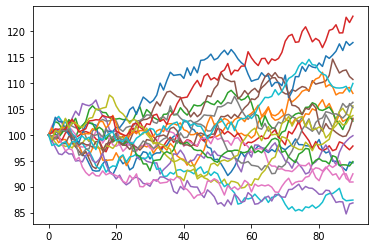

In [3]:
S0 = 100
sig = 0.2
r=0.05

M = 40000   #train set 개수
m = 10000   #test set 개수
N = 90   #계약기간 (일)

dt = 1/365
T = N*dt
sigsdt = sig * np.sqrt(dt)

rv = np.random.normal(r*dt,sigsdt,[M,N])
S_train = np.empty([M,N+1])
for i in range(M):
    S_train[i,0] = S0
    for j in range(N):
        S_train[i,j+1] = S_train[i,j] * (1+rv[i,j])

rv_test = np.random.normal(r*dt,sigsdt,[m,N])
S_test = np.empty([m,N+1])
for i in range(m):
    S_test[i,0] = S0
    for j in range(N):
        S_test[i,j+1] = S_test[i,j] * (1+rv_test[i,j])

Smax_train=np.max(S_train,axis=1)
Smin_train=np.min(S_train,axis=1)
Smax_test=np.max(S_test,axis=1)
Smin_test=np.min(S_test,axis=1)

for i in range(20):
    plt.plot(S_train[i,:])

plt.plot()

In [4]:
K=100

#payoff 배열
LCfloat=np.empty([M])
for i in range(M):
    LCfloat[i]=S_train[i,-1]-Smin_train[i]

LPfloat=np.empty([M])
for i in range(M):
    LPfloat[i]=Smax_train[i]-S_train[i,-1]

LCfixed=np.empty([M])
for i in range(M):
    LCfixed[i]=np.maximum(Smax_train[i]-K,0)

LPfixed=np.empty([M])
for i in range(M):
    LPfixed[i]=np.maximum(K-Smin_train[i],0)


#test set payoff
LCfloat_t=np.empty([m])
for i in range(m):
    LCfloat_t[i]=S_test[i,-1]-Smin_test[i]

LPfloat_t=np.empty([m])
for i in range(m):
    LPfloat_t[i]=Smax_test[i]-S_test[i,-1]

LCfixed_t=np.empty([m])
for i in range(m):
    LCfixed_t[i]=np.maximum(Smax_test[i]-K,0)

LPfixed_t=np.empty([m])
for i in range(m):
    LPfixed_t[i]=np.maximum(K-Smin_test[i],0)

In [5]:
#룩백 옵션 가격 monte carlo
# print(LCflo_price(S0,T,r,sig))
# print(LPflo_price(S0,T,r,sig))
# print(np.mean(LCfloat)*np.exp(-r*T))
# print(np.mean(LPfloat)*np.exp(-r*T))
# print(np.mean(LCfixed)*np.exp(-r*T))
# print(np.mean(LPfixed)*np.exp(-r*T))

In [6]:
#이자율 보정
S_input_train = np.empty([M,N+1])
for i in range(M):
    for j in range(N+1):
        S_input_train[i,j]= np.exp(r*dt*(N-j))*S_train[i,j]


S_input_test = np.empty([m,N+1])
for i in range(m):
    for j in range(N+1):
        S_input_test[i,j]= np.exp(r*dt*(N-j))*S_test[i,j]


In [7]:
#delta 정의
def delta_model(model_name=None):
    price = tf.keras.layers.Input(shape=(1,))

    delta = tf.keras.layers.Dense(256)(price)
    delta = tf.keras.layers.BatchNormalization()(delta)
    delta = tf.keras.layers.Activation('relu')(delta)
    delta = tf.keras.layers.Dense(512)(delta)
    delta = tf.keras.layers.BatchNormalization()(delta)
    delta = tf.keras.layers.Activation('relu')(delta)
    delta = tf.keras.layers.Dense(512)(delta)
    delta = tf.keras.layers.BatchNormalization()(delta)
    delta = tf.keras.layers.Activation('relu')(delta)
    delta = tf.keras.layers.Dense(512)(price)
    delta = tf.keras.layers.BatchNormalization()(delta)
    delta = tf.keras.layers.Activation('relu')(delta)
    delta = tf.keras.layers.Dense(128)(price)
    delta = tf.keras.layers.BatchNormalization()(delta)
    delta = tf.keras.layers.Activation('relu')(delta)
    delta = tf.keras.layers.Dense(64)(price)
    delta = tf.keras.layers.BatchNormalization()(delta)
    delta = tf.keras.layers.Activation('relu')(delta)
    delta = tf.keras.layers.Dense(1)(delta)

    delta = tf.keras.layers.Activation('sigmoid')(delta)
    # #-sigmoid 활성화 함수
    # def sigm(x):
    #   return -tf.keras.activations.sigmoid(x)
    # delta = tf.keras.layers.Activation(sigm)(delta)

    return tf.keras.Model(inputs=price, outputs=delta, name=model_name)

In [8]:
#모델 정의
price = tf.keras.layers.Input(shape=(1,), name="price")
my_input = [price]

hedge_cost = tf.keras.layers.Lambda(lambda x: x*0.0)(price)

for j in range(N):
    delta = delta_model(model_name="delta_"+str(j))(price)

    new_price = tf.keras.layers.Input(shape=(1,), name='S'+str(j+1))
    my_input += [new_price]

    price_inc = tf.keras.layers.Subtract(name='price_inc_'+str(j))([price, new_price])
    cost = tf.keras.layers.Multiply(name="stock_"+str(j))([delta, price_inc])
    hedge_cost = tf.keras.layers.Add(name='cost_'+str(j))([hedge_cost, cost])

    price = new_price

payoff = tf.keras.layers.Input(shape=(1,), name='payoff')
my_input += [payoff]

cum_cost = tf.keras.layers.Add(name="hedge_cost_plus_payoff")([hedge_cost, payoff])

model = tf.keras.Model(inputs=my_input, outputs=cum_cost)

In [9]:
SS = [S_input_train[:,i].reshape(M,1) for i in range(N+1)]

#payoff=np.maximum(S_train[:,-1]-K, 0)
payoff=LCfloat
#payoff=LPfloat
#payoff=LCfixed
#payoff=LPfixed
x = [SS] + [payoff]

#y=bscall(S0, K, T, r, sig)*np.exp(r*T)* np.ones([M,1])
y = np.mean(LCfloat)* np.ones([M,1])
#y = np.mean(LPfloat)* np.ones([M,1])
#y = np.mean(LCfixed)* np.ones([M,1])
#y = np.mean(LPfixed)* np.ones([M,1])

model.compile(loss='mse', optimizer='adam')

In [10]:
hist = model.fit(x,y, batch_size=256, epochs=30, verbose=True, validation_split=0.2)

Epoch 1/30
125/125 [==============================] - 44s 107ms/step - loss: 5.4465 - val_loss: 20.3105
Epoch 2/30
125/125 [==============================] - 8s 61ms/step - loss: 2.8519 - val_loss: 14.3695
Epoch 3/30
125/125 [==============================] - 7s 59ms/step - loss: 2.5230 - val_loss: 10.2851
Epoch 4/30
125/125 [==============================] - 10s 81ms/step - loss: 2.3849 - val_loss: 7.9741
Epoch 5/30
125/125 [==============================] - 7s 59ms/step - loss: 2.3095 - val_loss: 7.8656
Epoch 6/30
125/125 [==============================] - 7s 59ms/step - loss: 2.2817 - val_loss: 7.6889
Epoch 7/30
125/125 [==============================] - 7s 55ms/step - loss: 2.2657 - val_loss: 7.3831
Epoch 8/30
125/125 [==============================] - 7s 60ms/step - loss: 2.2551 - val_loss: 8.0260
Epoch 9/30
125/125 [==============================] - 6s 49ms/step - loss: 2.2501 - val_loss: 6.8080
Epoch 10/30
125/125 [==============================] - 6s 49ms/step - loss: 2.2446 - 

313/313 [==============================] - 8s 13ms/step
평균  7.81345
표준편차  2.8673267
최대-평균  10.421301
평균-최소  10.227827
7.825613438588272


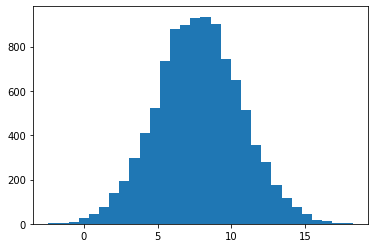

In [11]:
SS = [S_input_test[:,i].reshape(m,1) for i in range(N+1)]
payoff=LCfloat_t
x = [SS] + [payoff]

y_pred=model.predict(x)
mean=np.mean(y_pred)
print('평균 ',mean)
print('표준편차 ',np.std(y_pred))
print('최대-평균 ',np.max(y_pred)-mean)
print('평균-최소 ',mean-np.min(y_pred))
print(np.mean(LCfloat_t))

plt.hist(y_pred, bins=30)
plt.show()